# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import os.path

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Quick exploration of data before pre-processing

> To asses the pre-processing needs

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')

In [4]:
type(portfolio.channels[0])

list

Portfolio channel data is a list instead of string

In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Values are dictionaries, we will have to asses that later.

Clients columns is named as person. In the profile df as is id. We will have to match this later.

In [6]:
# Which kind of events are in the dataset
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [7]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


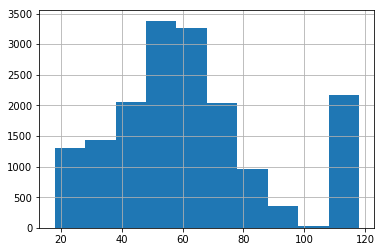

In [10]:
profile.age.hist()

In [11]:
profile.age.value_counts().sort_index()[-5:]

98        5
99        5
100      12
101       5
118    2175
Name: age, dtype: int64

In [12]:
profile[profile.age == 118][:10]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [14]:
sum(profile.gender.isnull())

2175

We have no client data (gender, age or income) for 2175 of 17000 clients.

## Pre-processing

In [15]:
ids = profile[profile.age==118].id.values

In [16]:
profile = profile[~profile.id.isin(ids)]

In [17]:
portfolio.channels = [str(channel) for channel in portfolio.channels]

In [18]:
portfolio.groupby(['offer_type','duration','difficulty','channels']).reward.max()

offer_type     duration  difficulty  channels                            
bogo           5         5           ['web', 'email', 'mobile', 'social']     5
                         10          ['web', 'email', 'mobile', 'social']    10
               7         5           ['web', 'email', 'mobile']               5
                         10          ['email', 'mobile', 'social']           10
discount       7         7           ['web', 'email', 'mobile', 'social']     3
                         10          ['web', 'email', 'mobile']               2
               10        10          ['web', 'email', 'mobile', 'social']     2
                         20          ['web', 'email']                         5
informational  3         0           ['email', 'mobile', 'social']            0
               4         0           ['web', 'email', 'mobile']               0
Name: reward, dtype: int64

In [19]:
transcript = transcript.rename({'person': 'id'}, axis=1)

In [20]:
portfolio.channels.value_counts()

['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['email', 'mobile', 'social']           2
['web', 'email']                        1
Name: channels, dtype: int64

In [21]:
#transcript[transcript.event == 'offer completed']

In [22]:
df = pd.merge(transcript, profile, on='id', how='outer')

In [23]:
df.head()

,event,id,time,value,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509.0,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509.0,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},75.0,20170509.0,F,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75.0,20170509.0,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},75.0,20170509.0,F,100000.0


In [24]:
df.sort_values(by='time',ascending=True, inplace=True)

In [25]:
df.head()

,event,id,time,value,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75.0,20170509.0,F,100000.0
20759,offer received,55289282866847c681072561a2cd5474,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,NaN,NaN
138583,offer received,119a7e0359554181b0f9a502ac351ad5,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},55.0,20180110.0,F,80000.0
138593,offer received,4b34026864b64d00ad0a5fa9d7dcdec2,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},52.0,20170512.0,F,79000.0
138611,offer received,ba786181b0634188a68dd4e240a41ab7,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},61.0,20180318.0,M,78000.0


In [26]:
# ver las transacciones conseguidas para esa oferta

# juntarlo todo con la demografia

In [27]:
df_viewed = transcript[transcript.event == 'offer viewed']

In [28]:
df_viewed.head()

,event,id,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [29]:
df_viewed.value = [value['offer id'] for value in df_viewed.value]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [30]:
portfolio = portfolio.rename({'id': 'offer_id'}, axis=1)

In [31]:
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward
0,"['email', 'mobile', 'social']",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"['web', 'email', 'mobile', 'social']",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"['web', 'email', 'mobile']",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"['web', 'email', 'mobile']",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"['web', 'email']",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [32]:
df_offers = transcript[transcript.event == 'offer received']
df_offers.head()

,event,id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [33]:
df_offers.value = [value['offer id'] for value in df_offers.value]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
df_offers = df_offers.rename({'value': 'offer_id'}, axis=1)

In [35]:
df_offers = pd.merge(df_offers, portfolio, on='offer_id', how='outer')

In [36]:
df_offers.head()

,event,id,time,offer_id,channels,difficulty,duration,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5


In [37]:
df_offers = df_offers[~df_offers.id.isin(ids)]

In [38]:
df_offers = df_offers.rename({'id': 'client_id'}, axis=1)

In [39]:
df_offers.shape

(66501, 9)

In [40]:
df_completed = transcript[transcript.event == 'offer completed']
df_completed.value = [value['offer_id'] for value in df_completed.value]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [41]:
df_completed.head()

,event,id,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [42]:
df_transactions = transcript[transcript.event == 'transaction']

In [43]:
df_transactions.value = [value['amount'] for value in df_transactions.value]

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [44]:
df_transactions.head()

,event,id,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [45]:
df_offers.shape

(66501, 9)

In [46]:
fname = 'df_offers.csv'
load = 1

if os.path.isfile(fname) & load == 1:  
    print('Loading File')
    df_offers = pd.read_csv('df_offers.csv')
    df_offers.drop('Unnamed: 0',axis=1, inplace=True)
else:
    df_offers['viewed'] = False
    df_offers['completed'] = False
    for i in tqdm(range(df_offers.shape[0])):
        client = df_offers.iloc[i].client_id
        timespan = df_offers.iloc[i].time + df_offers.iloc[i].duration
        offer_id = df_offers.iloc[i].offer_id
        if (df_viewed[(df_viewed.id == client) & (df_viewed.time <= timespan) & (df_viewed.value == offer_id)]).shape[0] >= 1:
                df_offers['viewed'].iloc[i] = True
        if (df_completed[(df_completed.id == client) & (df_completed.time <= timespan) & (df_completed.value == offer_id)]).shape[0] >= 1:
                df_offers['completed'].iloc[i] = True
    df_offers.to_csv('df_offers.csv')

Loading File


In [47]:
load = 1
if os.path.isfile(fname) & load == 1:  
    print('Loading File')
    df_offers = pd.read_csv('df_offers.csv')
    df_offers.drop('Unnamed: 0',axis=1, inplace=True)
else:
    df_offers['n_transactions'] = 0
    df_offers['amount_transactions'] = 0
    for i in tqdm(range(df_offers.shape[0])):
        client = df_offers.iloc[i].client_id
        timespan = df_offers.iloc[i].time + df_offers.iloc[i].duration
        offer_id = df_offers.iloc[i].offer_id
        n_transactions = df_transactions[(df_transactions.id == client) & (df_transactions.time <= timespan)].shape[0]
        amount  = df_transactions[(df_transactions.id == client) & (df_transactions.time <= timespan)].value.sum()
        if n_transactions >= 1:
            df_offers['n_transactions'].iloc[i] = n_transactions
            df_offers['amount_transactions'].iloc[i] = amount
    df_offers.to_csv('df_offers.csv')

Loading File


In [48]:
df_offers.shape

(66501, 13)

## 3. Data Exploration and Visualizations

In [49]:
# Number of clients, we know from the previous section we don't have personal data for 2175 of them.
profile.shape[0]

14825

In [50]:
profile.gender.value_counts(normalize=True)

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

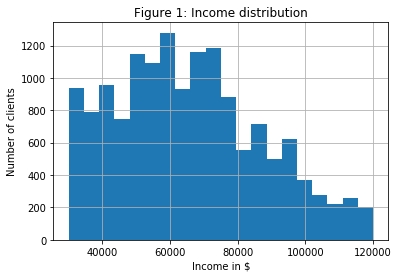

In [51]:
profile.income.hist(bins=20)
plt.title('Figure 1: Income distribution')
plt.xlabel('Income in $')
plt.ylabel('Number of clients');

In [52]:
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

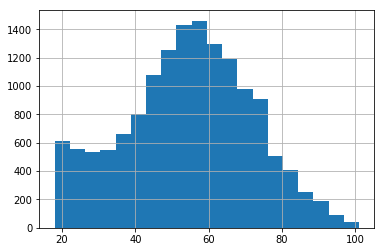

In [53]:
profile.age.hist(bins=20)

In [54]:
profile.age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [55]:
# Number of offers
portfolio.offer_id.shape[0]

10

In [56]:
df_offers.head()

,event,client_id,time,offer_id,channels,difficulty,duration,offer_type,reward,viewed,completed,n_transactions,amount_transactions
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,True,False,0,0.0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0


In [57]:
df_offers.n_transactions.value_counts()

0     16749
2      7634
1      7446
3      7166
4      5947
5      4875
6      3800
7      3027
8      2342
9      1842
10     1463
11     1126
12      806
13      681
14      472
15      352
16      243
17      174
18      132
19       78
20       61
21       30
22       21
23       15
24        9
26        5
25        3
28        1
29        1
Name: n_transactions, dtype: int64

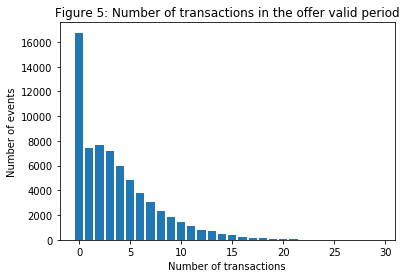

In [58]:
# Number of transactions after offer received during the duration period
n_trans = df_offers.n_transactions.value_counts()
plt.bar(n_trans.index,n_trans.values)
plt.title('Figure 5: Number of transactions in the offer valid period')
plt.xlabel('Number of transactions')
plt.ylabel('Number of events')
plt.show()

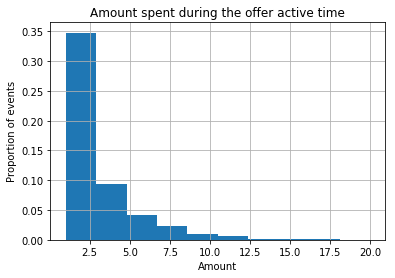

In [59]:
# Amount spent after offer received during the duration period
df_offers.amount_transactions.value_counts().sort_index()[1:].hist(bins = 10, density = True)
plt.title('Amount spent during the offer active time')
plt.xlabel('Amount')
plt.ylabel('Proportion of events');

In [60]:
df_offers.shape

(66501, 13)

In [61]:
# offers viewed in the active offer period
df_offers.viewed.value_counts()

False    45162
True     21339
Name: viewed, dtype: int64

In [62]:
df_offers.viewed.value_counts(normalize=True)

False    0.679118
True     0.320882
Name: viewed, dtype: float64

In [63]:
# offers completed in the active offer period
df_offers.completed.value_counts()

False    58381
True      8120
Name: completed, dtype: int64

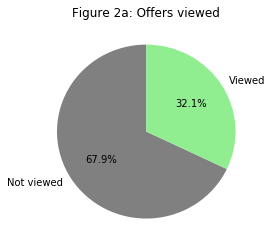

In [64]:
# offers completed in the active offer period as percentage

plt.figure(figsize=(4, 4))
sizes= df_offers.viewed.value_counts()
labels = ['Not viewed','Viewed']
plt.pie(sizes, labels = labels, startangle = 90, autopct = lambda x: f'{round(x,1)}%', colors=['gray','lightgreen'])
plt.title('Figure 2a: Offers viewed')
plt.show() 

Text(0.5,1,'Figure 2b: Offers completed')

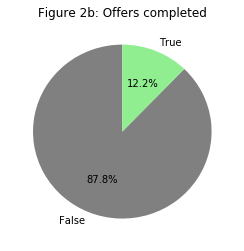

In [65]:
# offers completed in the active offer period as percentage

plt.figure(figsize=(4, 4))
sizes= df_offers.completed.value_counts()
labels = df_offers.completed.value_counts().index
plt.pie(sizes, labels = labels, startangle = 90, autopct = lambda x: f'{round(x,1)}%', colors=['gray','lightgreen'])
plt.title('Figure 2b: Offers completed')

In [66]:
df_offers.groupby('offer_type').viewed.value_counts(normalize=True)*100

offer_type     viewed
bogo           False     65.557523
               True      34.442477
discount       False     65.732823
               True      34.267177
informational  False     76.977444
               True      23.022556
Name: viewed, dtype: float64

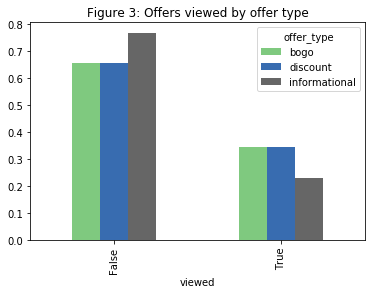

In [67]:
df_offers.groupby('offer_type').viewed.value_counts(normalize=True).unstack(0).plot.bar(cmap = 'Accent')
plt.title('Figure 3: Offers viewed by offer type');

In [68]:
df_offers.groupby(['completed']).viewed.value_counts(normalize=True)*100

completed  viewed
False      False     73.604426
           True      26.395574
True       True      73.017241
           False     26.982759
Name: viewed, dtype: float64

Text(0.5,1,'Figure 4: Number of offers completed in relation to their viewed status')

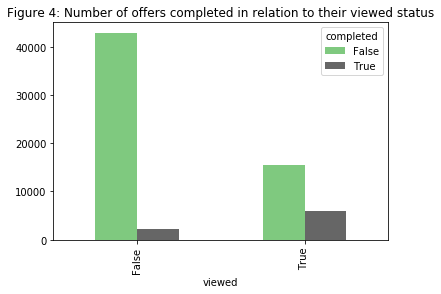

In [69]:
df_offers.groupby('completed').viewed.value_counts().unstack(0).plot.bar(cmap='Accent')
plt.title('Figure 4: Number of offers completed in relation to their viewed status')

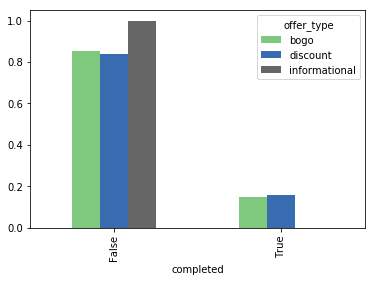

In [70]:
df_offers.groupby('offer_type').completed.value_counts(normalize=True).unstack(0).plot.bar(cmap = 'Accent')

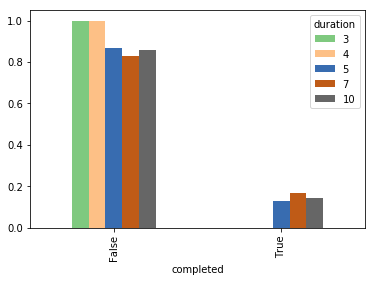

In [71]:
df_offers.groupby('duration').completed.value_counts(normalize=True).unstack(0).plot.bar(cmap = 'Accent')

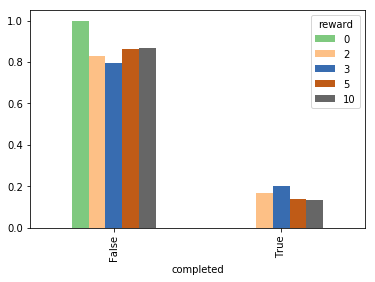

In [72]:
df_offers.groupby('reward').completed.value_counts(normalize=True).unstack(0).plot.bar(cmap = 'Accent')

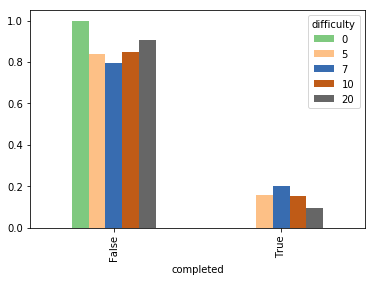

In [73]:
df_offers.groupby('difficulty').completed.value_counts(normalize=True).unstack(0).plot.bar(cmap = 'Accent')

In [74]:
# añadir número y valor transacciones en los siguientes 5 - 10 - 20 días
# Hacer gráficas y sacar informaciones tipo, los que ven las ofertas las convierten x más, 
# influencia de reward, duración y dificultad
# ver diferencias respecto a la media
# sacar media de edad, genero y tiempo en la compañia para diferentes ofertas completadas, o cuand reciben información.
# intentar predecir si una oferta enviada se va a completar

In [75]:
df_offers.head()

,event,client_id,time,offer_id,channels,difficulty,duration,offer_type,reward,viewed,completed,n_transactions,amount_transactions
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,True,False,0,0.0
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0


In [76]:
profile.rename(columns={'id': 'client_id'}, inplace=True)

In [77]:
# Join all info in a dataframe

df = pd.merge(df_offers, profile, on='client_id', how='outer')

In [78]:
profile.head()

,age,became_member_on,gender,client_id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [79]:
df_completed = df[df.completed == True]
df_not_completed = df[df.completed == False]

In [80]:
df_completed.age.mean(),df_completed.income.mean()

(56.255911330049258, 70314.408866995072)

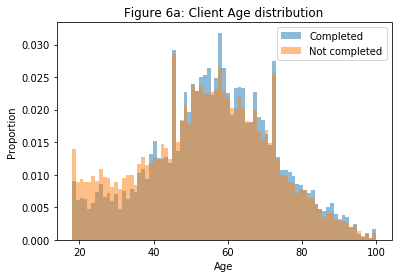

In [81]:
x = list(df_completed.age.values)
y = list(df_not_completed.age.values)

bins = np.linspace(18, 100, 80)

plt.hist(x, bins, alpha=0.5, label='Completed', density = True)
plt.hist(y, bins, alpha=0.5, label='Not completed', density = True)
plt.legend(loc='upper right')
plt.title('Figure 6a: Client Age distribution')
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.show()

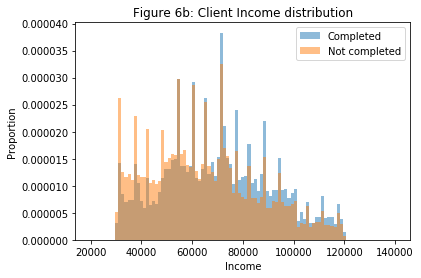

In [82]:
x = list(df_completed.income.values)
y = list(df_not_completed.income.values)

bins = np.linspace(20000, 140000, 100)

plt.hist(x, bins, alpha=0.5, label='Completed', density = True)
plt.hist(y, bins, alpha=0.5, label='Not completed', density = True)
plt.legend(loc='upper right')
plt.title('Figure 6b: Client Income distribution')
plt.xlabel('Income')
plt.ylabel('Proportion')
plt.show()

In [83]:
type(x)

list

In [84]:
df_completed.gender.value_counts(normalize=True)*100

M    49.384236
F    48.940887
O     1.674877
Name: gender, dtype: float64

In [85]:
df_not_completed.age.mean(),df_not_completed.income.mean()

(54.106849831280726, 64684.143813912058)

In [86]:
df_not_completed.gender.value_counts(normalize=True)*100

M    58.441959
F    40.221990
O     1.336051
Name: gender, dtype: float64

In [87]:
channels_df = df_offers['channels'].str.replace(']','').str.replace('[','').str.replace(' ','').str.replace('\'','').str.get_dummies(sep=',')

In [88]:
df_offers = pd.concat([df_offers,channels_df],axis=1)
#df_offers.drop('channels',axis=1, inplace=True)

In [89]:
df_offers.head()

,event,client_id,time,offer_id,channels,difficulty,duration,offer_type,reward,viewed,completed,n_transactions,amount_transactions,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,True,False,0,0.0,1,1,0,1
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0,1,1,0,1
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0,1,1,0,1
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0,1,1,0,1
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",5,7,bogo,5,False,False,0,0.0,1,1,0,1


## 4. Modeling

Objective: Predict if an offer will be completed.

### 4.1 Model Preparation

In [90]:
df.columns

Index(['event', 'client_id', 'time', 'offer_id', 'channels', 'difficulty',
       'duration', 'offer_type', 'reward', 'viewed', 'completed',
       'n_transactions', 'amount_transactions', 'age', 'became_member_on',
       'gender', 'income'],
      dtype='object')

In [91]:
# Create dummy variables / one hot enconding for categorical variables

df = pd.get_dummies(df, columns=['offer_type','gender','offer_id'])

# Completed column as int instead string
df.dropna(inplace=True)
df.completed = df.completed.astype(int)

In [92]:
df.head()

,event,client_id,time,channels,difficulty,duration,reward,viewed,completed,n_transactions,...,offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7,offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2,offer_id_2906b810c7d4411798c6938adc9daaa5,offer_id_3f207df678b143eea3cee63160fa8bed,offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0,offer_id_5a8bc65990b245e5a138643cd4eb9837,offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9,offer_id_ae264e3637204a6fb9bb56bc8210ddfd,offer_id_f19421c1d4aa40978ebb69ca19b0e20d,offer_id_fafdcd668e3743c1bb461111dcafc2a4
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,"['web', 'email', 'mobile']",5.0,7.0,5.0,True,0,0.0,...,0,0,0,0,0,0,1,0,0,0
1,offer received,78afa995795e4d85b5d9ceeca43f5fef,504.0,"['web', 'email', 'mobile', 'social']",5.0,5.0,5.0,False,0,5.0,...,0,0,0,0,0,0,0,0,1,0
2,offer received,78afa995795e4d85b5d9ceeca43f5fef,408.0,"['email', 'mobile', 'social']",10.0,7.0,10.0,True,0,5.0,...,0,0,0,0,0,0,0,1,0,0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,168.0,"['email', 'mobile', 'social']",0.0,3.0,0.0,False,0,2.0,...,0,0,0,0,0,1,0,0,0,0
4,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0.0,"['web', 'email', 'mobile']",5.0,7.0,5.0,False,0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [93]:
df_model = df.drop(['event','client_id','channels','viewed'], axis=1)

In [94]:
df_model.columns

Index(['time', 'difficulty', 'duration', 'reward', 'completed',
       'n_transactions', 'amount_transactions', 'age', 'became_member_on',
       'income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'offer_id_0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'offer_id_2298d6c36e964ae4a3e7e9706d1fb8c2',
       'offer_id_2906b810c7d4411798c6938adc9daaa5',
       'offer_id_3f207df678b143eea3cee63160fa8bed',
       'offer_id_4d5c57ea9a6940dd891ad53e9dbe8da0',
       'offer_id_5a8bc65990b245e5a138643cd4eb9837',
       'offer_id_9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'offer_id_ae264e3637204a6fb9bb56bc8210ddfd',
       'offer_id_f19421c1d4aa40978ebb69ca19b0e20d',
       'offer_id_fafdcd668e3743c1bb461111dcafc2a4'],
      dtype='object')

In [95]:
X = df_model.drop(['completed'],axis=1).values
y = df_model.completed.values

In [96]:
# Create train and validation set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle = True)

In [97]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46550, 25), (19951, 25), (46550,), (19951,))

In [98]:
# Accuracy if we predict only not completed:
1-y_test.mean()

0.87684827828179035

### 4.2 Model training and predictions 

In [99]:
# Import Models

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Import metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [100]:
# Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(f'Accuray Naive Bayes: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score Naive Bayes: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray Naive Bayes: 85.59%
f1-score Naive Bayes: 35.03%


In [101]:
# Simple Neural Network 

mlp = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(f'Accuray Neural Network: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score Neural Network: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray Neural Network: 87.68%
f1-score Neural Network: 0.0%


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
# K-Neighbours

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(f'Accuray KNeighbors: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'Accuray KNeighbors: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray KNeighbors: 86.4%
Accuray KNeighbors: 10.72%


In [103]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f'Accuray Random Forest: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score Random Forest: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray Random Forest: 87.68%
f1-score Random Forest: 0.0%


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
# Refinement

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# K-Neighbours

parameters = {'n_neighbors':[1,3,5,10],'weights':['uniform', 'distance'],'leaf_size':[10,20,30]}

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters,scoring='f1_micro')
clf.fit(X_train, y_train)

neigh = KNeighborsClassifier(n_neighbors = clf.best_params_['n_neighbors'], 
                             leaf_size = clf.best_params_['leaf_size'],
                            weights = clf.best_params_['weights'])
neigh.fit(X_train, y_train)

y_pred = neigh.predict(X_test)

print(f'Accuray K-Neighbours: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score K-Neighbours: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray K-Neighbours: 87.46%
f1-score K-Neighbours: 2.11%


In [106]:
# Simple Neural Network

parameters = {'max_iter':[10,100,200],'hidden_layer_sizes':[64,128,256], 'activation':['tanh','relu'], 
              'learning_rate':['constant','adaptive'],'early_stopping':[False, True]}

clf = GridSearchCV(estimator=MLPClassifier(), param_grid=parameters,scoring='f1_micro' )
clf.fit(X_train, y_train)

mlp = MLPClassifier(max_iter = clf.best_params_['max_iter'],
                    hidden_layer_sizes= clf.best_params_['hidden_layer_sizes'], 
                    activation = clf.best_params_['activation'])
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

print(f'Accuray MLP: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score MLP: {round(100*f1_score(y_test, y_pred),2)}%')

/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuray MLP: 87.68%
f1-score MLP: 0.0%


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Random Forest Classifier

parameters = {'n_estimators':[100,200,1000],'min_samples_split':[2,5,10]}

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters,scoring='f1_micro')
clf.fit(X_train, y_train)

rf = RandomForestClassifier(min_samples_split=clf.best_params_['min_samples_split'],
                            n_estimators=clf.best_params_['n_estimators'])

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'Accuray Random Forest: {round(100*accuracy_score(y_test, y_pred),2)}%')
print(f'f1-score Random Forest: {round(100*f1_score(y_test, y_pred),2)}%')

Accuray Random Forest: 88.23%
f1-score Random Forest: 22.76%


In [ ]:
clf.best_params_